In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import Dataset class
from torch.utils.data import Dataset, DataLoader
import os
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Felipe de Jesus\miniconda3\envs\MLearn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# given a audio, add noise to it
def add_noise(audio, noise_level):
    noise = torch.randn(audio.shape)
    return audio + noise_level * noise


In [125]:
from math import floor


class NoiseDataset(Dataset):
    def __init__(self, Audios_path):
        # read the path and add the aurios
        self.X = []
        self.SRc = []
        self.y = []
        self.len = 0
        # check the number of files in the path
        for file in os.listdir(Audios_path):
            if file.endswith(".wav"):
                self.len += 1
        # read the files
        for file in os.listdir(Audios_path):
            if file.endswith(".wav"):
                # read the file
                audio, sr = torchaudio.load(Audios_path + file)
                # for each channel sum the channels and average them
                audio = torch.mean(audio, dim=0).unsqueeze(0)
                # resample the audio
                #print (audio.shape)
                print (sr)
                rate_resample = floor(sr / 1000)*250
                print (rate_resample)
                self.SRc.append(rate_resample)
                audio = torchaudio.functional.resample(audio, sr, rate_resample)
                #print (audio.shape)
                # add noise to the audio
                audio_noise = add_noise(audio, 0.1)
                # add the audio to the dataset
                # Round the dimension to the nearest multiple of 100
                audio = audio[:, :floor(audio.shape[1] / 1000) * 1000]
                audio_noise = audio_noise[:, :floor(audio_noise.shape[1] / 1000) * 1000]
                self.X.append(audio)
                self.y.append(audio_noise)
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return self.len

In [205]:
class NoiseCleaner(nn.Module):

    def __init__(self, num_channels=1):
        super(NoiseCleaner, self).__init__()
        # the input is a 1xN tensor, the N is not fixed
        # Input: [batch_size, 1, N]
        self.conv1 = nn.Conv1d(num_channels, 128, kernel_size=16, stride=2, padding=7) # [batch_size, 16, N/2]
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128, 128, kernel_size=16, stride=5, padding=7) # [batch_size, 32, N/10]
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=16, stride=2, padding=7) # [batch_size, 64, N/20]
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(256)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=16, stride=5, padding=7) # [batch_size, 128, N/100]
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm1d(512)
        self.conv5 = nn.Conv1d(512, 1024, kernel_size=16, stride=2, padding=7) # [batch_size, 256, N/200]
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm1d(1024)
        self.conv6 = nn.Conv1d(1024, 2048, kernel_size=16, stride=5, padding=7) # [batch_size, 512, N/1000]
        self.relu6 = nn.ReLU()
        self.bn6 = nn.BatchNorm1d(2048)
        self.Tconv1 = nn.ConvTranspose1d(2048, 1024, kernel_size=16, stride=10, padding=3) # [batch_size, 256, N/100]
        self.relu7 = nn.ReLU()
        self.bn7 = nn.BatchNorm1d(1024)
        self.Tconv2 = nn.ConvTranspose1d(1024, 1, kernel_size=16, stride=10, padding=3) # [batch_size, 64, N]
        self.relu9 = nn.ReLU()
        self.bn9 = nn.BatchNorm1d(1)
        self.TLast = nn.ConvTranspose1d(1, num_channels, kernel_size=16, stride=10, padding=3) # [batch_size, 1, N]
        # Tanh
        self.tanh = nn.Tanh()

    def forward(self, x):
        #print (x.shape)
        x = self.bn1(self.relu1(self.conv1(x)))
        #print (x.shape)
        x = self.bn2(self.relu2(self.conv2(x)))
        #print (x.shape)
        x = self.bn3(self.relu3(self.conv3(x)))
        #print (x.shape)
        x = self.bn4(self.relu4(self.conv4(x)))
        #print (x.shape)
        x = self.bn5(self.relu5(self.conv5(x)))
        #print (x.shape)
        x = self.bn6(self.relu6(self.conv6(x)))
        #print (x.shape)
        x = self.bn7(self.relu7(self.Tconv1(x)))
        #print (x.shape)
        x = self.bn9(self.relu9(self.Tconv2(x)))
        #print (x.shape)
        x = self.TLast(x)
        #print (x.shape)
        x = self.tanh(x)
        return x

In [206]:
# make a sample of padding_mode = 'circular'
# the input is a 1xN tensor, the N is not fixed
# Input: [batch_size, 1, N]
sample = torch.randn(1,1, 16000)
# make a model
model = NoiseCleaner(num_channels=1)
# print the output
print(model(sample).shape)

torch.Size([1, 1, 16000])


In [157]:
# make a dataset
dataset = NoiseDataset("Audios/")

44100
11000
44100
11000
44100
11000
44100
11000
44100
11000
44100
11000
44100
11000
44100
11000


In [61]:
for data in dataset:
    print (data[0].shape)
    print (data[1].shape)
    

torch.Size([1, 50000])
torch.Size([1, 50000])
torch.Size([1, 22000])
torch.Size([1, 22000])
torch.Size([1, 40000])
torch.Size([1, 40000])
torch.Size([1, 74000])
torch.Size([1, 74000])
torch.Size([1, 13000])
torch.Size([1, 13000])
torch.Size([1, 69000])
torch.Size([1, 69000])
torch.Size([1, 37000])
torch.Size([1, 37000])
torch.Size([1, 74000])
torch.Size([1, 74000])


In [62]:
import Audio_vs as avs
# hear the audio
sample_int = 2
avs.Audio(dataset[sample_int][0], dataset.SRc[sample_int])

In [63]:
# numpy array to tensor
waveform = torch.from_numpy(dataset[0][0].numpy()).unsqueeze(0)

In [183]:
print (waveform.shape)
output = model(waveform)

torch.Size([1, 1, 50000])


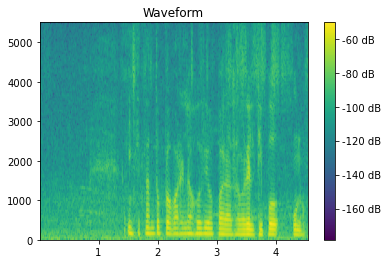

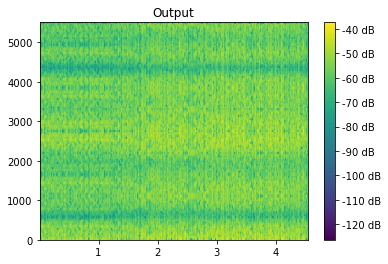

In [184]:
# plot the waveform with 2 channels
plt.figure()
plt.specgram(waveform[0,0,:].numpy(), Fs=dataset.SRc[0])
plt.colorbar(format='%+2.0f dB')
plt.title('Waveform')
plt.show()
plt.figure()
plt.specgram(output[0][0].detach().numpy(), Fs=dataset.SRc[0])
plt.colorbar(format='%+2.0f dB')
plt.title('Output')
plt.show()

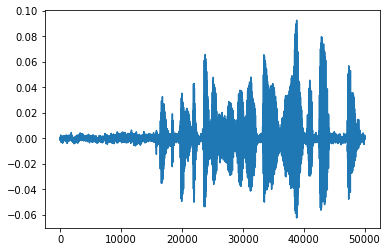

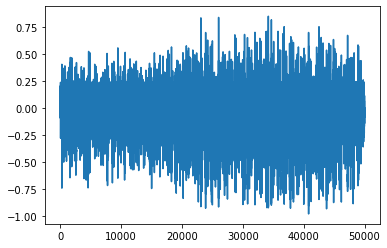

In [185]:
# plot the output with 2 channels
plt.figure()
plt.plot(waveform[0, 0, :].detach().numpy())
plt.show()
plt.figure()
plt.plot(output[0, 0, :].detach().numpy())
plt.show()

In [207]:
# define the loss function and the optimizer
criterion = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [208]:
# train the model
num_epochs = 100
for epoch in range(num_epochs):

    for i, (data, target) in enumerate(dataset):
        #print (data.shape)
        #print (target.shape)
        # forward pass
        #print (data.shape)
        output = model(data.unsqueeze(0))
        #print (output.shape)
        loss = criterion(output, target.unsqueeze(0))
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # print the loss
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            

Epoch [1/100], Loss: 0.0146
Epoch [2/100], Loss: 0.0142
Epoch [3/100], Loss: 0.0138
Epoch [4/100], Loss: 0.0135
Epoch [5/100], Loss: 0.0131
Epoch [6/100], Loss: 0.0128
Epoch [7/100], Loss: 0.0125
Epoch [8/100], Loss: 0.0123
Epoch [9/100], Loss: 0.0120
Epoch [10/100], Loss: 0.0118
Epoch [11/100], Loss: 0.0115
Epoch [12/100], Loss: 0.0113
Epoch [13/100], Loss: 0.0111
Epoch [14/100], Loss: 0.0109
Epoch [15/100], Loss: 0.0108
Epoch [16/100], Loss: 0.0106
Epoch [17/100], Loss: 0.0104
Epoch [18/100], Loss: 0.0103
Epoch [19/100], Loss: 0.0101
Epoch [20/100], Loss: 0.0100
Epoch [21/100], Loss: 0.0099
Epoch [22/100], Loss: 0.0097
Epoch [23/100], Loss: 0.0096
Epoch [24/100], Loss: 0.0095
Epoch [25/100], Loss: 0.0094
Epoch [26/100], Loss: 0.0093
Epoch [27/100], Loss: 0.0092
Epoch [28/100], Loss: 0.0091
Epoch [29/100], Loss: 0.0090
Epoch [30/100], Loss: 0.0089
Epoch [31/100], Loss: 0.0089
Epoch [32/100], Loss: 0.0088
Epoch [33/100], Loss: 0.0087


KeyboardInterrupt: 

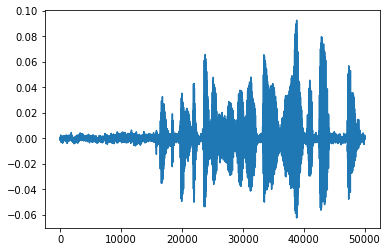

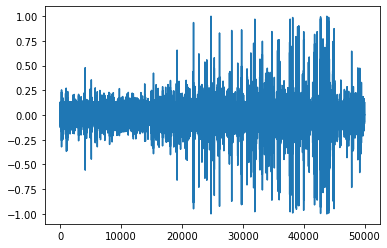

In [209]:
sample_out = model(waveform)
plt.figure()
plt.plot(waveform[0, 0, :].detach().numpy())
plt.show()
plt.figure()
plt.plot(sample_out[0, 0, :].detach().numpy())
plt.show()

In [210]:
# hear the audio of the output
avs.Audio(sample_out[0,0,:].detach().numpy(), dataset.SRc[0])